# Проект по Методи и софтуер за машинно обучение
Студент: Кристиян Кръчмаров <br>
Фак. номер: 791324005 <br>


## Зареждане на данните

In [1]:
import pandas as pd

path = "../Data/"
data = pd.read_csv(path + "shuffle_email_spam_classification.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB


In [2]:
data = data.iloc[:, 1:]  # remove 'Email No' column

X = data.iloc[:, :-1]  # explanatory variables
Y = data.iloc[:, -1]  # result

print(X.shape)
print(Y.shape)

(5172, 3000)
(5172,)


## Helpers
Няколко helper метода за улеснение <br>

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone
import matplotlib.pyplot as plt


def get_metrics(classifier, x_train, y_train, x_test, y_test):
    classifier = clone(classifier)
    classifier.fit(x_train, y_train)

    predicted = classifier.predict(x_test)
    probabilities = classifier.predict_proba(x_test)
    probabilities = probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probabilities)
    auc = roc_auc_score(y_test, probabilities)

    conf_matrix = confusion_matrix(y_test, predicted)

    accuracy = classification_report(y_test, predicted, output_dict=True)['accuracy']
    cl_report = classification_report(y_test, predicted, output_dict=False)

    return {
        "ACC": accuracy,
        "AUC": auc,
        "TPR": tpr,
        "FPR": fpr,
        "Threshold": threshold,
        "ConfusionMatrix": conf_matrix,
        "ClassificationReport": cl_report,
    }


In [4]:
def get_metrics_train_and_test(classifier, X_train, Y_train, X_test, Y_test, plot_roc_curve=False):
    fg, axes = plt.subplots(1, 2, figsize=(20, 8))

    axes[0].set_xlim([-0.05, 1.05])
    axes[0].set_ylim([-0.05, 1.05])
    axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
    axes[0].title.set_text("ROC (Test set)")

    axes[1].set_xlim([-0.05, 1.05])
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
    axes[1].title.set_text("ROC (Training set)")

    train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
    train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

    if plot_roc_curve:
        axes[0].plot(train_test["FPR"], train_test["TPR"], marker="", color="green", alpha=0.6)
        axes[1].plot(train_train["FPR"], train_train["TPR"], marker="", color="red", alpha=0.6)
        plt.show()

    return {
        "train-train": train_train,
        "train-test": train_test,
    }

In [32]:
from sklearn.model_selection import KFold


def k_fold_validation(classifier, X, Y, splits=10, plot_curve=False):
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)

    fg, axes = plt.subplots(1, 2, figsize=(20, 8))

    axes[0].set_xlim([-0.05, 1.05])
    axes[0].set_ylim([-0.05, 1.05])
    axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
    axes[0].title.set_text("k-Fold ROC (Test set)")

    axes[1].set_xlim([-0.05, 1.05])
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
    axes[1].title.set_text("k-Fold ROC (Training set)")

    performance_df = pd.DataFrame(
        columns=["Fold", "ACC Test", "ACC Training", "ACC ratio", "AUC Test", "AUC Training", "AUC ratio", "CONF_MTX"])

    i = 0
    for trainIndex, testIndex in kf.split(X):
        X_train, X_test = X[trainIndex], X[testIndex]
        Y_train, Y_test = Y[trainIndex], Y[testIndex]

        metrics_train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
        metrics_train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

        axes[0].plot(metrics_train_test["FPR"], metrics_train_test["TPR"], marker="", color="blue", alpha=0.6)
        axes[1].plot(metrics_train_train["FPR"], metrics_train_train["TPR"], marker="", color="orange", alpha=0.6)

        temp = {'Fold': i,
                'ACC Test': metrics_train_test["ACC"],
                'ACC Training': metrics_train_train["ACC"],
                'ACC ratio': metrics_train_test["ACC"] / metrics_train_train["ACC"],
                'AUC Test': metrics_train_test["AUC"],
                'AUC Training': metrics_train_train["AUC"],
                'AUC ratio': metrics_train_test["AUC"] / metrics_train_train["AUC"],
                'CONF_MTX': metrics_train_test["ConfusionMatrix"]}

        temp_df = pd.DataFrame([temp])
        performance_df = pd.concat([performance_df, temp_df], ignore_index=True)
        i=i+1

    if plot_curve:
        plt.show()

    return performance_df

## 1. Logistic Regression
Тъй като логистичната регресия е чуствителна към мащаба на входните данни ще трябва да се приложи някакъв вид preprocessing. <br>
В случая ще използвам `Normalizer`

In [34]:
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

normalizer = Normalizer()

X_norm = normalizer.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


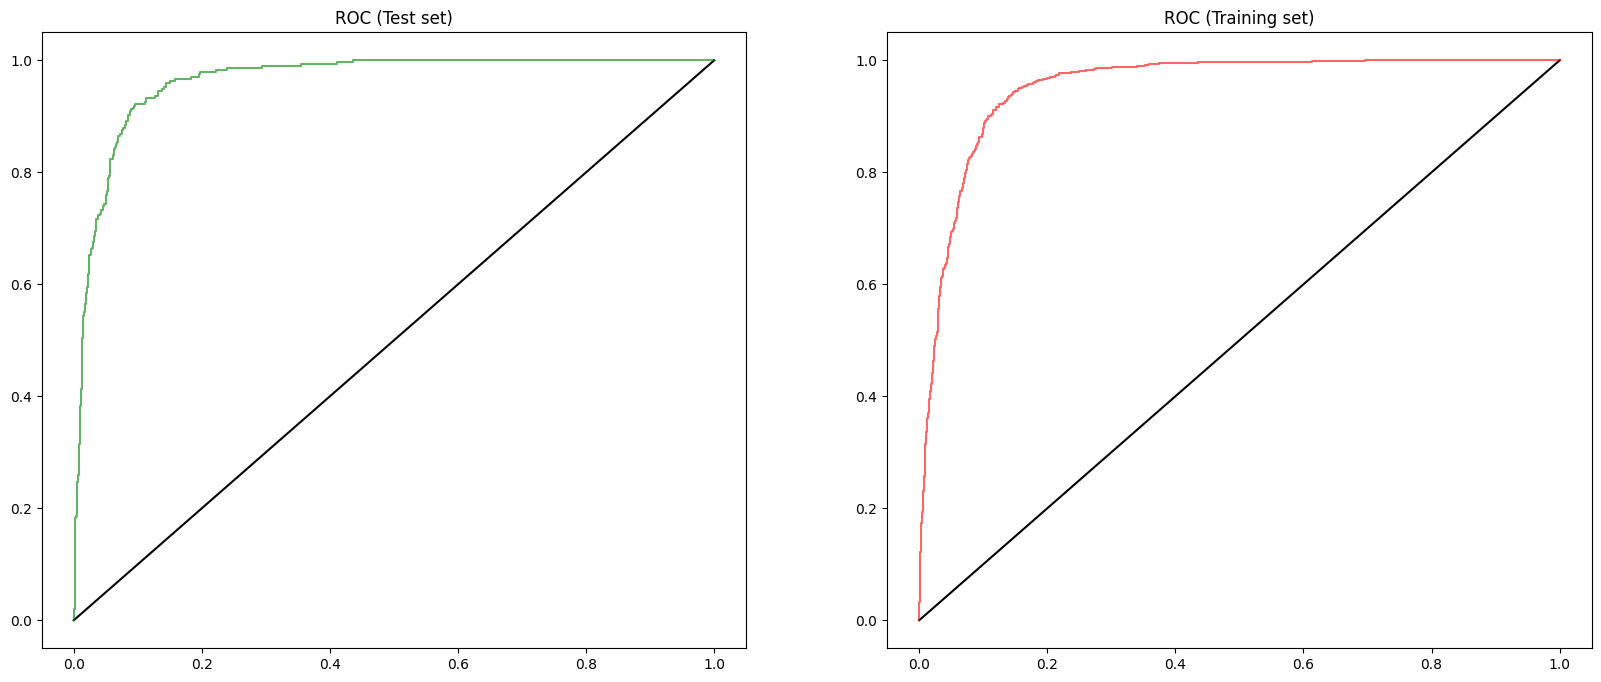

In [35]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

In [36]:
lr_train_train = lr_metrics_train_and_test.get('train-train', 'not-found')
lr_train_test = lr_metrics_train_and_test.get('train-test', 'not-found')
print("Train-Train AUC: {}".format(lr_train_train.get('AUC', 'not-found')))
print("Train-Test AUC: {}".format(lr_train_test.get('AUC', 'not-found')))
print("\n")
print("Train-Train ACC: {}".format(lr_train_train.get('ACC', 'not-found')))
print("Train-Test ACC: {}".format(lr_train_test.get('ACC', 'not-found')))

Train-Train AUC: 0.952991675662328
Train-Test AUC: 0.9637338624145119


Train-Train ACC: 0.8709209572153734
Train-Test ACC: 0.8859903381642512


C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_5096\154508586.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


KeyboardInterrupt: 

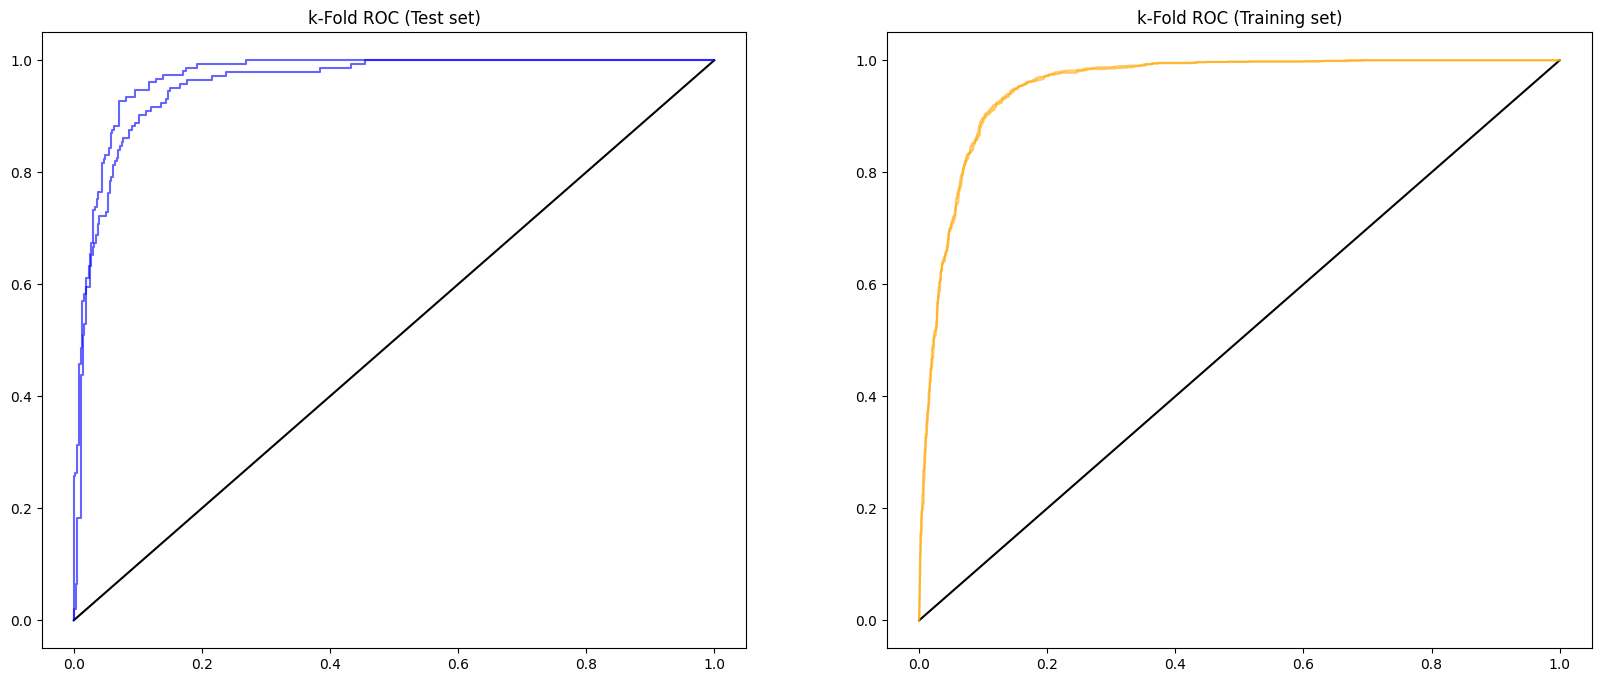

In [38]:
k_fold_metrics = k_fold_validation(logistic_regression, X_norm, Y)
k_fold_metrics.head(10)

Може ли тези стойностти да са по високи?<br>

In [10]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


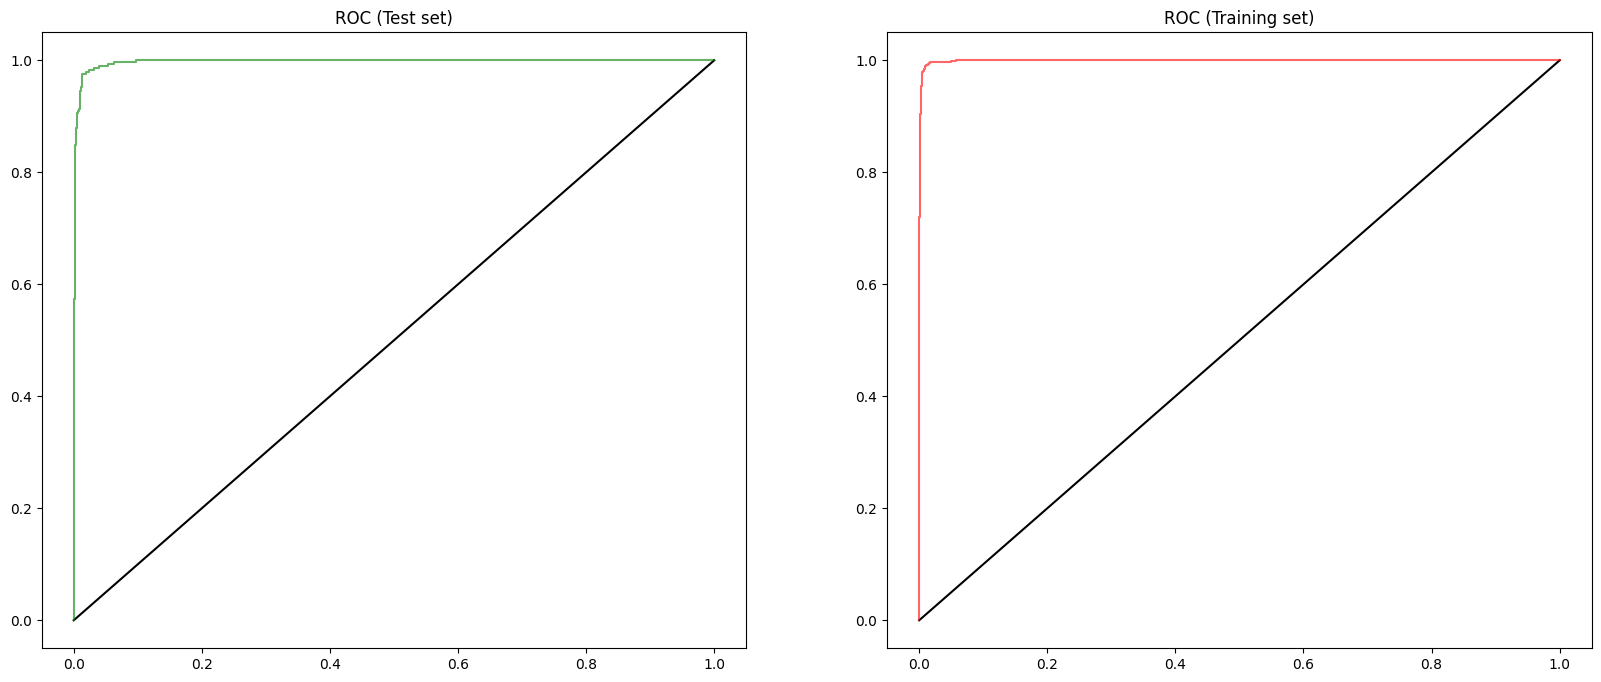

In [11]:
logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)

In [12]:
lr_train_train = lr_metrics_train_and_test.get('train-train', 'not-found')
lr_train_test = lr_metrics_train_and_test.get('train-test', 'not-found')
print("Train-Train AUC: {}".format(lr_train_train.get('AUC', 'not-found')))
print("Train-Test AUC: {}".format(lr_train_test.get('AUC', 'not-found')))
print("\n")
print("Train-Train ACC: {}".format(lr_train_train.get('ACC', 'not-found')))
print("Train-Test ACC: {}".format(lr_train_test.get('ACC', 'not-found')))

Train-Train AUC: 0.9992679816001441
Train-Test AUC: 0.9973119262699778


Train-Train ACC: 0.9886391104665216
Train-Test ACC: 0.9835748792270531


C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_5096\154508586.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


,Fold,ACC Test,ACC Training,ACC ratio,AUC Test,AUC Training,AUC ratio,CONF_MTX
0,0,0.974903,0.985174,0.989575,0.996186,0.999291,0.996893,"[[359, 6], [7, 146]]"
1,1,0.984556,0.989901,0.994600,0.997920,0.999300,0.998619,"[[369, 5], [3, 141]]"
2,2,0.970986,0.985607,0.985166,0.998660,0.999242,0.999417,"[[358, 1], [14, 144]]"
3,3,0.965184,0.984318,0.980561,0.991193,0.999267,0.991920,"[[352, 9], [9, 147]]"
4,4,0.959381,0.983673,0.975304,0.990068,0.999370,0.990692,"[[363, 8], [13, 133]]"
5,5,0.974855,0.990333,0.984371,0.997490,0.999282,0.998206,"[[383, 6], [7, 121]]"
6,6,0.969052,0.984962,0.983847,0.990753,0.999306,0.991441,"[[361, 8], [8, 140]]"
7,7,0.959381,0.985392,0.973603,0.992301,0.999390,0.992906,"[[356, 6], [15, 140]]"
8,8,0.951644,0.985392,0.965752,0.991951,0.999416,0.992530,"[[363, 8], [17, 129]]"
9,9,0.970986,0.985177,0.985596,0.990887,0.999291,0.991590,"[[345, 6], [9, 157]]"


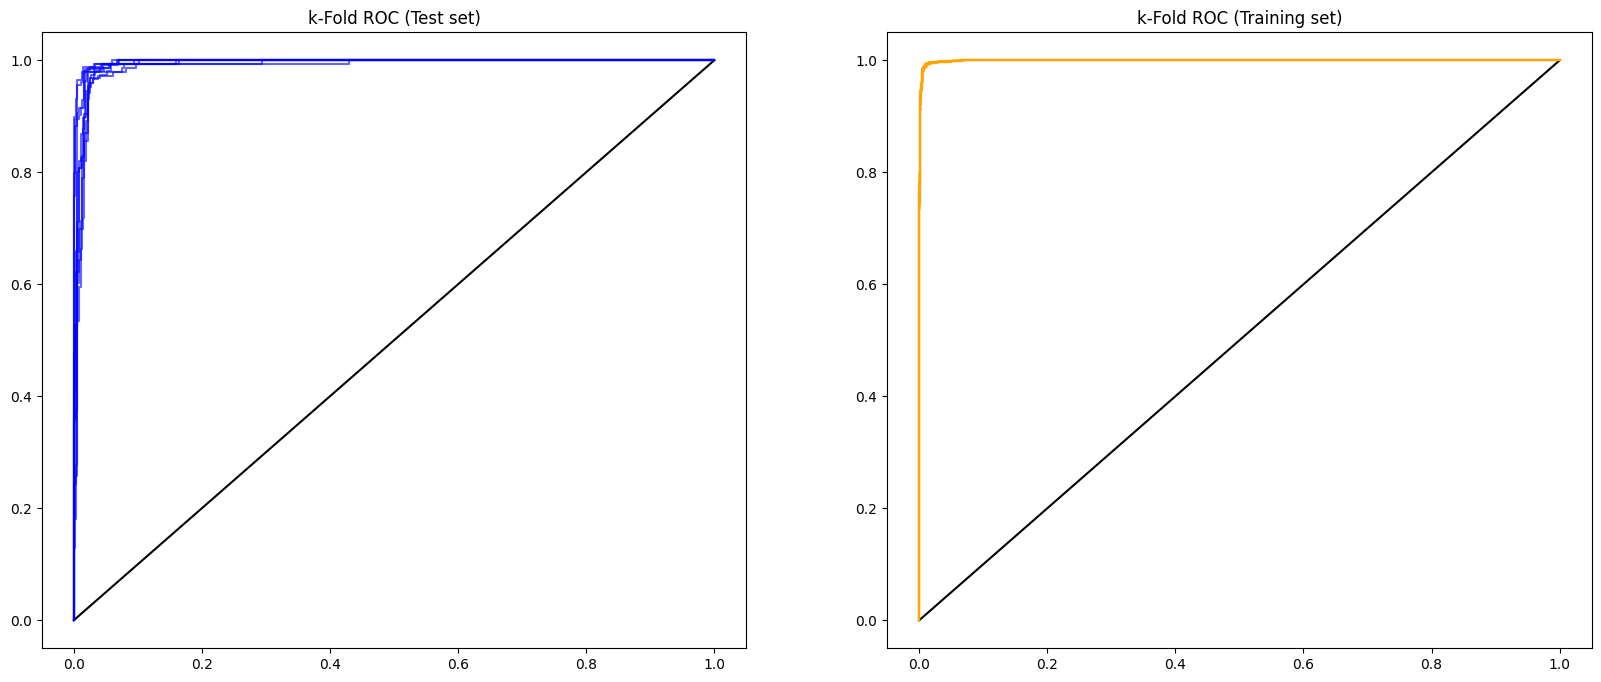

In [13]:
k_fold_metrics = k_fold_validation(logistic_regression, X_scaled, Y)
k_fold_metrics.head(10)

Има подобрение като се използва `MinMaxScaller`

In [14]:
stdScaler = StandardScaler()
X_std_scaled = stdScaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_std_scaled, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


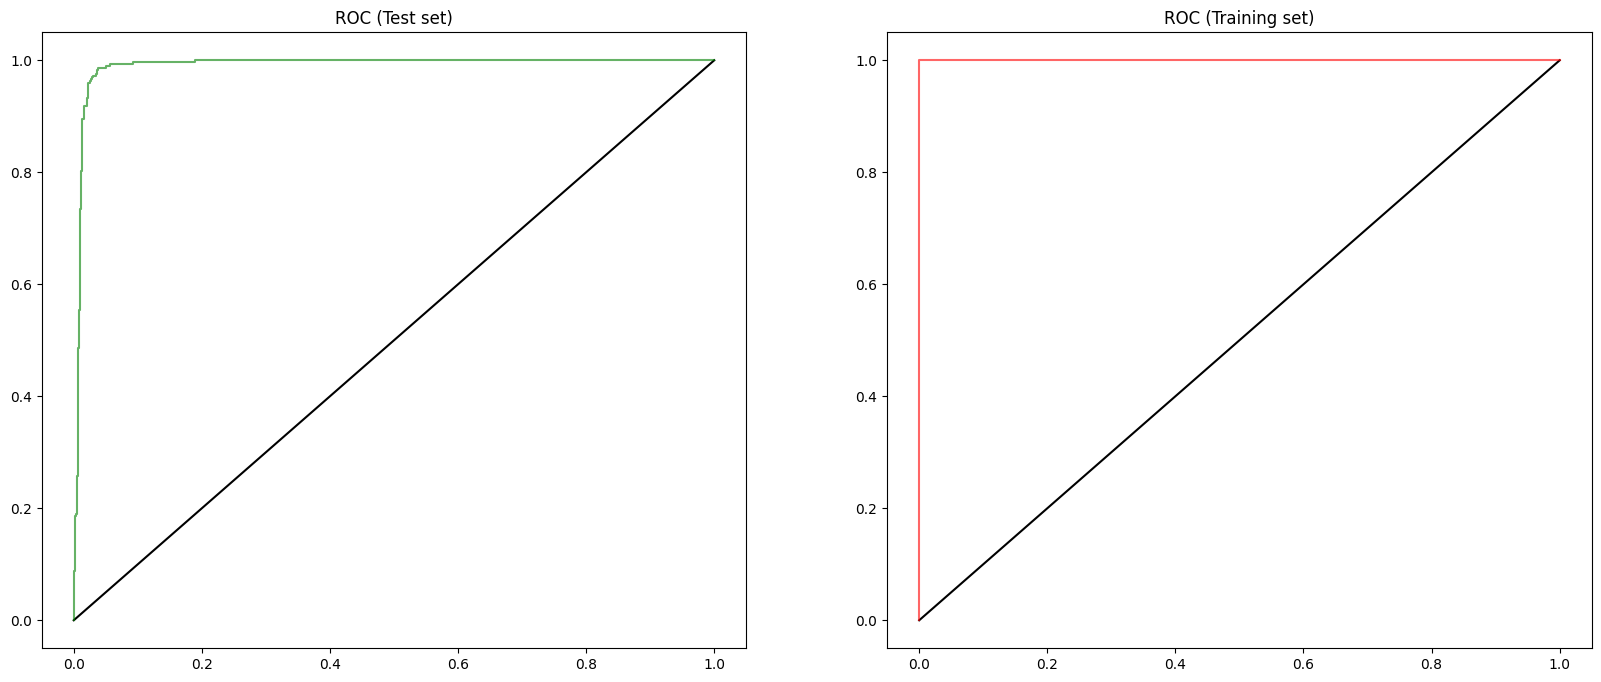

In [15]:
logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test,
                                                       plot_roc_curve=True)


In [16]:
lr_train_train = lr_metrics_train_and_test.get('train-train', 'not-found')
lr_train_test = lr_metrics_train_and_test.get('train-test', 'not-found')
print("Train-Train AUC: {}".format(lr_train_train.get('AUC', 'not-found')))
print("Train-Test AUC: {}".format(lr_train_test.get('AUC', 'not-found')))
print("\n")
print("Train-Train ACC: {}".format(lr_train_train.get('ACC', 'not-found')))
print("Train-Test ACC: {}".format(lr_train_test.get('ACC', 'not-found')))

Train-Train AUC: 1.0
Train-Test AUC: 0.9902687120732234


Train-Train ACC: 0.9997582789460963
Train-Test ACC: 0.970048309178744


$AUC = 1$ при обучителни данни и $AUC \approx 0.98$ при тестови данни е знак за лек overfitting

C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_5096\154508586.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, temp_df], ignore_index=True)


,Fold,ACC Test,ACC Training,ACC ratio,AUC Test,AUC Training,AUC ratio,CONF_MTX
0,0,0.965251,0.999785,0.965458,0.987089,1.0,0.987089,"[[351, 14], [4, 149]]"
1,1,0.965251,0.999785,0.965458,0.992294,1.0,0.992294,"[[360, 14], [4, 140]]"
2,2,0.978723,0.999785,0.978934,0.995716,1.0,0.995716,"[[350, 9], [2, 156]]"
3,3,0.969052,0.999785,0.969260,0.985670,1.0,0.985670,"[[349, 12], [4, 152]]"
4,4,0.970986,0.999785,0.971195,0.985341,1.0,0.985341,"[[360, 11], [4, 142]]"
5,5,0.970986,1.000000,0.970986,0.994075,1.0,0.994075,"[[378, 11], [4, 124]]"
6,6,0.957447,0.999785,0.957653,0.986258,1.0,0.986258,"[[351, 18], [4, 144]]"
7,7,0.959381,0.999785,0.959587,0.985119,1.0,0.985119,"[[349, 13], [8, 147]]"
8,8,0.969052,0.999785,0.969260,0.990825,1.0,0.990825,"[[364, 7], [9, 137]]"
9,9,0.967118,0.999785,0.967326,0.988141,1.0,0.988141,"[[339, 12], [5, 161]]"


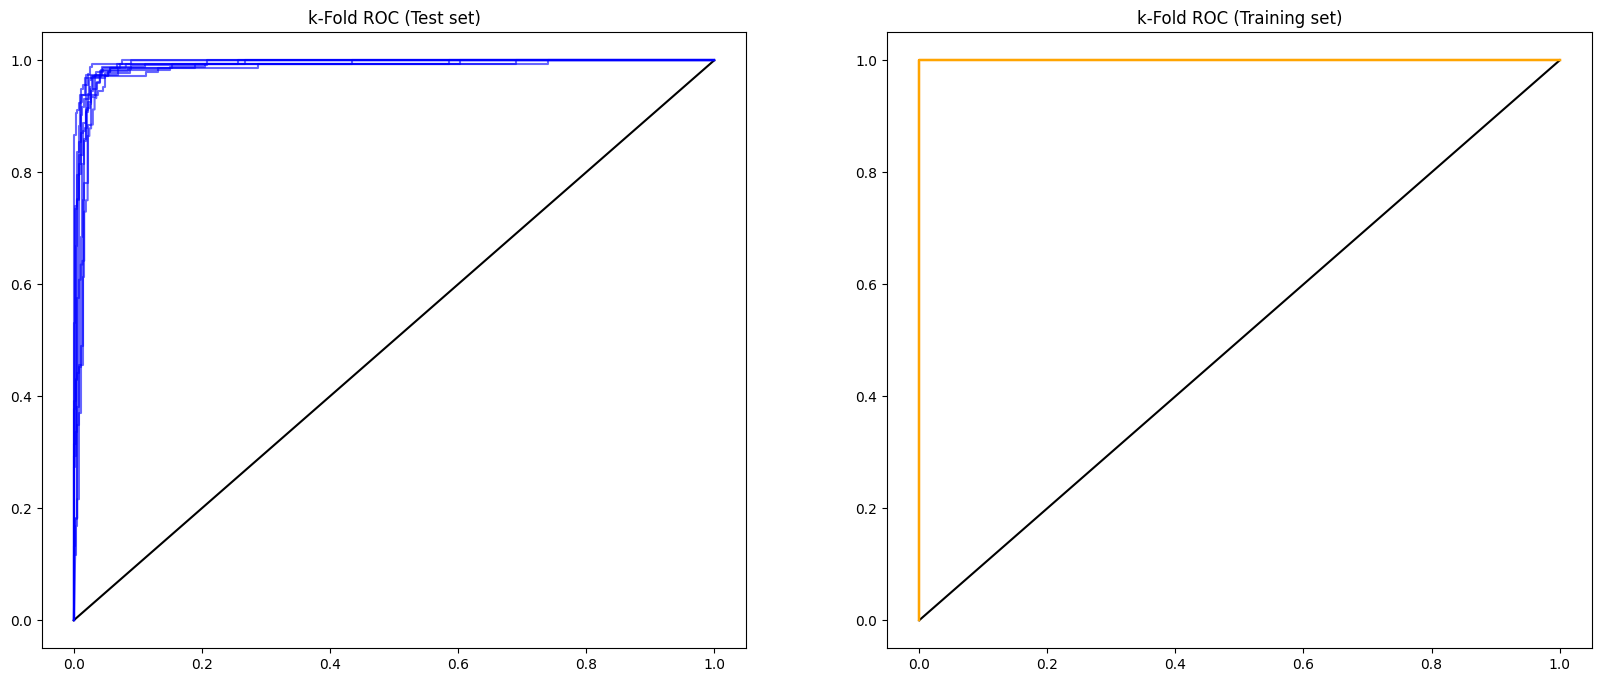

In [18]:
k_fold_metrics = k_fold_validation(logistic_regression, X_std_scaled, Y)
k_fold_metrics.head(10)

## 2. Random forest


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


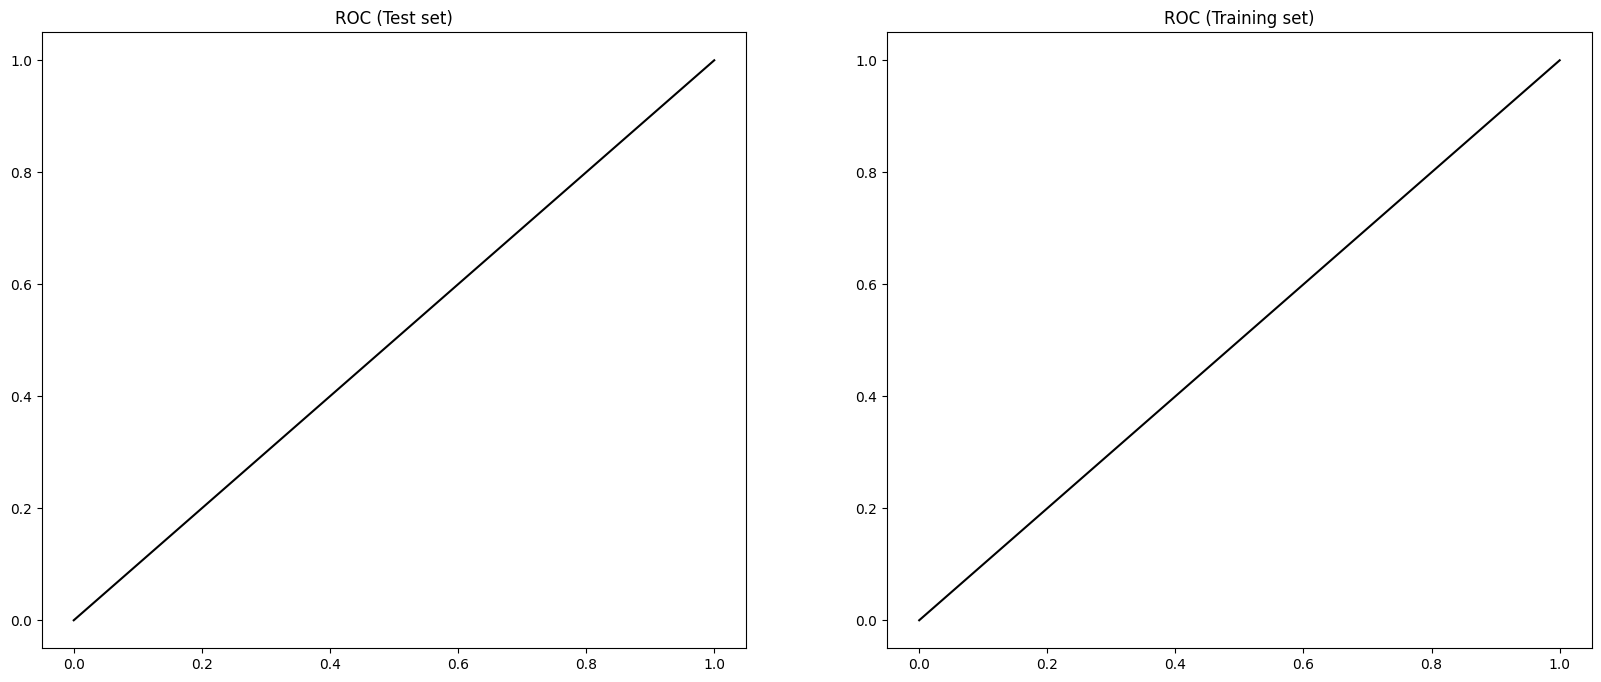

In [58]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test)

In [52]:
rf_train_train = rf_metrics_train_and_test.get('train-train', 'not-found')
rf_train_test = rf_metrics_train_and_test.get('train-test', 'not-found')
print("Train-Train AUC: {}".format(rf_train_train.get('AUC', 'not-found')))
print("Train-Test AUC: {}".format(rf_train_test.get('AUC', 'not-found')))
print("\n")
print("Train-Train ACC: {}".format(rf_train_train.get('ACC', 'not-found')))
print("Train-Test ACC: {}".format(rf_train_test.get('ACC', 'not-found')))

Train-Train AUC: 1.0
Train-Test AUC: 0.9946770499312872


Train-Train ACC: 1.0
Train-Test ACC: 0.9690821256038648


KeyError: "None of [Index([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,\n       ...\n       5158, 5159, 5161, 5162, 5163, 5164, 5165, 5166, 5169, 5171],\n      dtype='int64', length=4654)] are in the [columns]"

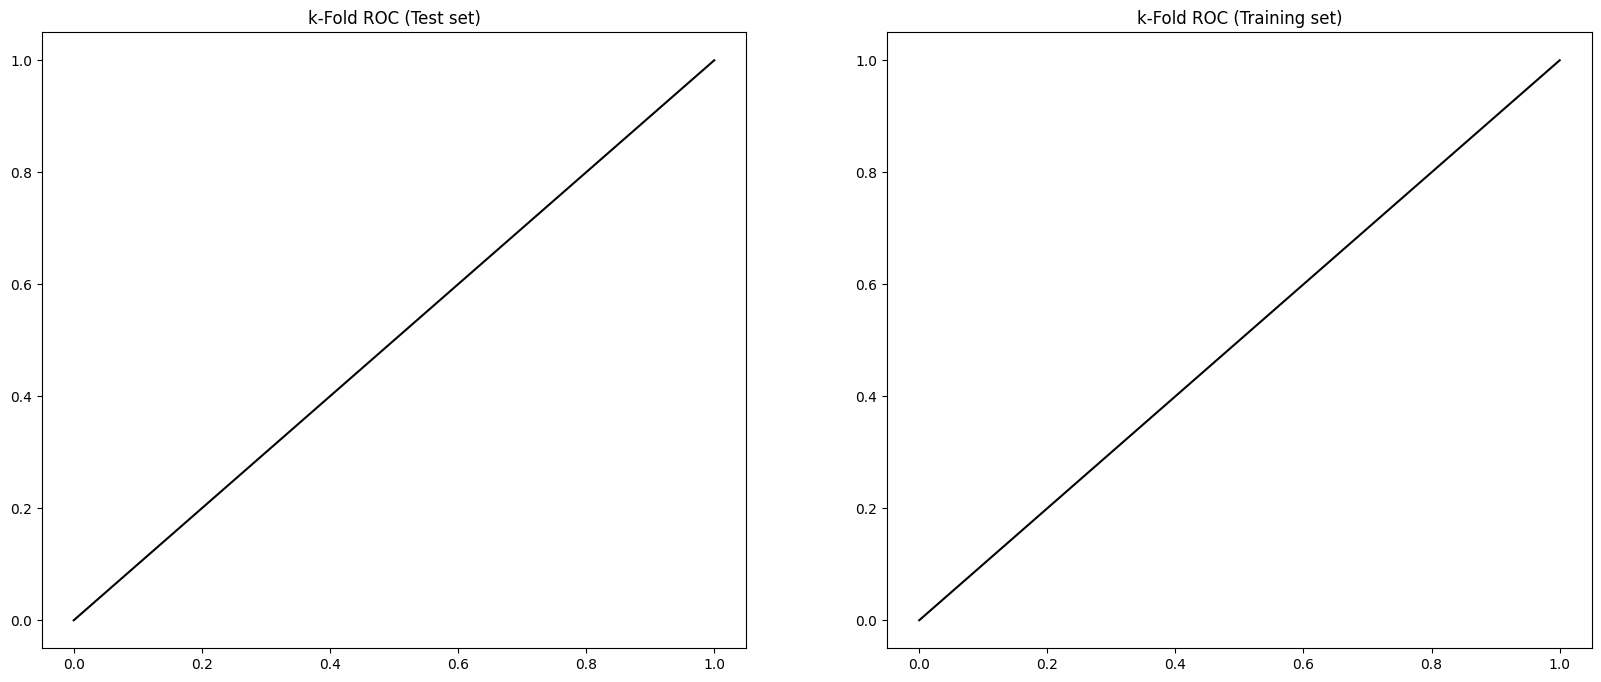

In [53]:
rf_k_fold_metrics = k_fold_validation(random_forest, X, Y)

In [44]:
data.head(4)

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
